In [106]:
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from bs4 import BeautifulSoup
import time
import re
import pandas as pd
import numpy as np
from unidecode import unidecode
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [107]:
df = pd.read_csv('riderlistcsv.csv')
df.head()

,type,Points,Name,url_fix
0,All Rounder,26,Remco Evenepoel,NaN
1,All Rounder,24,Primož Roglič,NaN
2,All Rounder,18,Geraint Thomas,NaN
3,All Rounder,16,João Almeida,NaN
4,All Rounder,14,Aleksandr Vlasov,NaN


In [108]:
"""Get ready to scrape the data- format the names"""
# define a function to remove accents
def remove_accents(text):
    return unidecode(text)

#Remove accents
df['Name_clean'] = df['Name'].apply(remove_accents)
#Remove trailing spaces
df['Name_clean'] = df['Name_clean'].str.strip()
# replace spaces with a dash in the Name column
df['Name_clean'] = df['Name_clean'].str.replace(' ', '-')
df.head()


,type,Points,Name,url_fix,Name_clean
0,All Rounder,26,Remco Evenepoel,NaN,Remco-Evenepoel
1,All Rounder,24,Primož Roglič,NaN,Primoz-Roglic
2,All Rounder,18,Geraint Thomas,NaN,Geraint-Thomas
3,All Rounder,16,João Almeida,NaN,Joao-Almeida
4,All Rounder,14,Aleksandr Vlasov,NaN,Aleksandr-Vlasov


In [109]:
""" Scrape points data from PCS """
#Choose whether to scrape:
collect = 0

if collect:
    for index, row in df.iterrows():
        if pd.isnull(row['url_fix']):
            urlname = row['Name_clean']
            url = f"http://www.procyclingstats.com/rider/{urlname}"
        else:
            url = row['url_fix']
            
            
        print(url)
        page = requests.get(url)
        soup = BeautifulSoup(page.content, "html.parser")
        
        rdr_info_find = soup.find_all('div', class_='rdr-info-cont')
        text = rdr_info_find[0].text

        #Extract additional stats
        try:
            age = re.findall(r'Date of birth:.*?\((\d+)\)', text)[0]
            weight = re.findall(r'Weight: (\d+) kg', text)[0]
            height = re.findall(r'Height: (\d+\.\d+) m', text)[0]
            oneday = re.findall(r"Points per specialty(\d+)", text)[0]
            GC = re.findall(r"One day races(\d+)", text)[0]
            TT = re.findall(r"GC(\d+)", text)[0]
            sprint = re.findall(r"Time trial(\d+)", text)[0]
            climber = re.findall(r"Sprint(\d+)", text)[0]
            
            #Store all of these stats 
            var_store = {'dob':age,'weight':weight,'height':height,'oneday':oneday,'GC':oneday,'TT':TT,'sprint':sprint,'climber':climber}
            for var_add in var_store:
                df.loc[index,var_add] = var_store[var_add]
                print(var_store[var_add])
        except:
            print("Issue with rider stats")    
            
        #Find points per year 
        my_spans = soup.find_all('table', class_='basic rdr-season-stats')

        for select_span in my_spans:
            
            rows_find = select_span.find_all('tr')
            #print(rows_find)
            for idx, row_ht in enumerate(rows_find):
                if idx == 0:
                    continue
                #print(row_ht)
                cols = row_ht.find_all('td')
                #print(cols)
                year = cols[0].text.strip()
                score = cols[1].find('span').text.strip()
                #print(f'Year: {year}, Score: {score}')
                row[year] = score
                df.loc[index,year] = score
        
    df.to_csv('saved_scrape_new.csv')

else:
    df = pd.read_csv('saved_scrape.csv')

In [110]:
#Convert scraped string to numeric
dfa = df
cols = list(df.columns)
string_cols = ['type','Name']
dfa.loc[dfa['Name']=='Damiano Caruso','Points']=10
cols_to_convert = [col for col in cols if col not in string_cols]
dfa[cols_to_convert] = dfa[cols_to_convert].apply(pd.to_numeric, errors='coerce')
dfa.head()


,Unnamed: 0,type,Points,Name,url_fix,Name_clean,dob,weight,height,oneday,...,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002
0,0,All Rounder,26,Remco Evenepoel,NaN,NaN,23.0,61.0,1.71,1889.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,All Rounder,24,Primož Roglič,NaN,NaN,33.0,65.0,1.77,1537.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,All Rounder,18,Geraint Thomas,NaN,NaN,36.0,71.0,1.83,1236.0,...,565.0,308.0,55.0,36.0,32.0,43.0,2.0,NaN,NaN,NaN
3,3,All Rounder,16,João Almeida,NaN,NaN,24.0,63.0,1.78,396.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,All Rounder,14,Aleksandr Vlasov,NaN,NaN,27.0,68.0,1.86,918.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



 Ranked best based on the SPC_cur metric:
       SPC_cur   SPC_past3                 Name
64  255.456416   90.763250            Ben Healy
36  161.695490   92.831830        Filippo Ganna
31  127.928723   64.865130  Einer Augusto Rubio
71  122.715327   52.905109      Henok Mulubrhan
40  120.309144  140.311381          Stefan Küng

 Ranked best based on the SPC_past3 metric:
       SPC_cur   SPC_past3            Name
40  120.309144  140.311381     Stefan Küng
80  119.908114  111.524927    Lorenzo Rota
11   97.149634  101.049878    Diego Ulissi
29  113.892657   94.519774  Patrick Konrad
36  161.695490   92.831830   Filippo Ganna


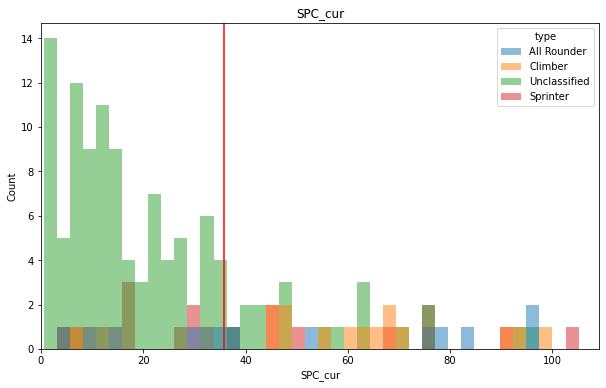

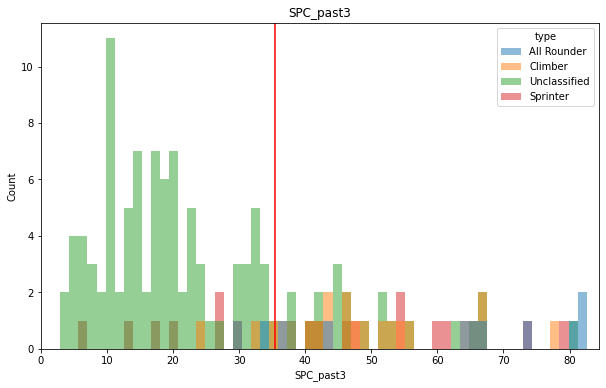

In [118]:
#Define valuation metrics and plot histogram
scale_factor = df['2022'].mean()/df['2023'].mean()
dfa['2023_scaled'] = dfa['2023']*scale_factor

dfa['SPC_cur'] = dfa['2023_scaled']/dfa['Points'].round(2)
dfa['SPC_past3'] = (dfa['2023_scaled']+dfa['2022']+dfa['2021'])/(3*dfa['Points']).round(2)

for score_metric in ('SPC_cur','SPC_past3'):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.histplot(data=dfa, x=score_metric,bins =100, hue='type', stat='count', edgecolor=None)
    ax.set_title(score_metric)
    ax.set_xlim(0,dfa[score_metric].quantile(0.95))
    ax.axvline(x = dfa[score_metric].mean(), color = 'r')
    print(f'\n Ranked best based on the {score_metric} metric:')
    print(dfa[['SPC_cur','SPC_past3','Name']].nlargest(5, score_metric))


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

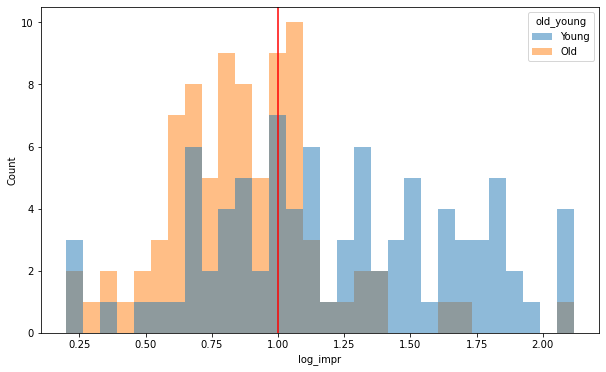

In [112]:
ylist = ['2023_scaled','2022','2021','2020']
#Make a list of yearly improvements 
templist = list()
for i in range(0,len(ylist)-1):
    plt.figure()
    newname = f'impr_{ylist[i]}'
    templist.append(newname)
    dfa[newname] = np.log(dfa[ylist[i]]/dfa[ylist[i+1]])

#Average the improvements
dfa['mean_impr'] = dfa[templist].mean(axis=1)
dfa['log_impr'] = dfa['mean_impr']

#Cap outliers
upper_pct = dfa['log_impr'].quantile(0.98)
dfa['log_impr'] = dfa['log_impr'].clip(upper=upper_pct)
lower_pct = dfa['log_impr'].quantile(0.02)
dfa['log_impr'] = dfa['log_impr'].clip(lower=lower_pct)

#Recenter at 1
dfa['log_impr'] = dfa['log_impr'] + 1
dfa['log_impr'] = dfa['log_impr']/dfa['log_impr'].median()

#Add a few more features
dfa['age_quantile'] = pd.qcut(dfa['dob'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
dfa['old_young'] = pd.qcut(dfa['dob'], q=2, labels=['Young', 'Old'])

#Plot improvements vs Age
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=dfa, x='log_impr',bins =30, hue='old_young', stat='count', edgecolor=None)
#ax.set_xlim(0,5)
ax.axvline(x = dfa['log_impr'].median(), color = 'r')

In [113]:
dfa['weight_PCS'] = dfa['SPC_past3']*dfa['log_impr'].round(2)
print('Avg. Improvement-weighted Cost  by Age quantile')
print(dfa.groupby('age_quantile')['weight_PCS'].mean())
dfa['age'] = dfa['dob'].round(0)

print('Avg. Improvement by Age quantile')
print(dfa.groupby('age_quantile')['log_impr'].mean())


Avg. Improvement-weighted Cost  by Age quantile
age_quantile
Q1    42.372631
Q2    39.538686
Q3    33.385406
Q4    35.585901
Name: weight_PCS, dtype: float64
Avg. Improvement by Age quantile
age_quantile
Q1    1.304736
Q2    1.134710
Q3    0.887346
Q4    0.851100
Name: log_impr, dtype: float64


In [114]:

df_disp = dfa[['Name','weight_PCS','type','age','Points','mean_impr']]

for type_name in df_disp['type'].unique():
    df_disp_cut = df_disp[df_disp['type'] == type_name]
    #print(df_disp_cut.nlargest(10, 'weight_PCS')
    tabplot = df_disp_cut.nlargest(10, 'weight_PCS')
    display(tabplot)

,Name,weight_PCS,type,age,Points,mean_impr
0,Remco Evenepoel,98.291692,All Rounder,23.0,26,0.342576
3,João Almeida,79.725751,All Rounder,24.0,16,0.110776
11,Diego Ulissi,76.797907,All Rounder,33.0,8,-0.139474
7,Brandon McNulty,70.606952,All Rounder,25.0,10,0.216884
10,Bauke Mollema,67.511871,All Rounder,36.0,8,-0.109684
1,Primož Roglič,66.803541,All Rounder,33.0,24,-0.060745
12,Rigoberto Urán,54.609805,All Rounder,36.0,8,-0.068822
4,Aleksandr Vlasov,49.784470,All Rounder,27.0,14,-0.228826
6,Pavel Sivakov,43.217337,All Rounder,25.0,12,0.138567
8,Warren Barguil,38.811539,All Rounder,31.0,8,-0.319300


,Name,weight_PCS,type,age,Points,mean_impr
21,Santiago Buitrago,111.319503,Climber,23.0,8,0.867453
31,Einer Augusto Rubio,109.622070,Climber,25.0,6,0.910403
29,Patrick Konrad,88.848588,Climber,31.0,6,0.061631
33,Ilan Van Wilder,87.339014,Climber,22.0,6,1.014965
17,Damiano Caruso,82.120538,Climber,35.0,10,0.199946
22,Lorenzo Fortunato,78.898540,Climber,26.0,8,0.716357
15,Jay Vine,76.823257,Climber,27.0,12,1.052718
27,Alessandro Covi,74.991465,Climber,24.0,6,0.276677
19,Thibaut Pinot,65.464143,Climber,32.0,10,0.164126
26,Jefferson Alexander Cepeda,60.046842,Climber,24.0,6,0.912313


,Name,weight_PCS,type,age,Points,mean_impr
64,Ben Healy,192.418090,Unclassified,22.0,6,1.414590
40,Stefan Küng,141.714495,Unclassified,29.0,8,0.142322
80,Lorenzo Rota,140.521408,Unclassified,27.0,6,0.421760
36,Filippo Ganna,101.186695,Unclassified,26.0,10,0.235815
74,Aurélien Paret-Peintre,90.086315,Unclassified,27.0,6,0.255308
71,Henok Mulubrhan,79.357664,Unclassified,23.0,6,0.693279
42,Giovanni Aleotti,75.439283,Unclassified,23.0,6,0.839262
37,Magnus Cort,74.817762,Unclassified,30.0,8,0.286450
52,Simon Clarke,72.677776,Unclassified,36.0,6,0.227800
154,Stephen Williams,60.948259,Unclassified,26.0,4,1.091979


,Name,weight_PCS,type,age,Points,mean_impr
161,Mark Cavendish,134.777046,Sprinter,37.0,8,0.911447
157,Mads Pedersen,98.779467,Sprinter,27.0,14,0.247124
167,Vincenzo Albanese,88.118463,Sprinter,26.0,6,0.679818
174,Marius Mayrhofer,79.100445,Sprinter,22.0,6,1.915192
168,Davide Ballerini,75.911555,Sprinter,28.0,6,0.165415
160,Michael Matthews,68.919628,Sprinter,32.0,10,-0.090194
164,Kaden Groves,61.101788,Sprinter,24.0,8,0.482862
159,Fernando Gaviria,58.326516,Sprinter,28.0,10,0.212983
175,Andrea Vendrame,55.208737,Sprinter,28.0,6,0.016573
172,Filippo Fiorelli,50.134808,Sprinter,NaN,6,0.394691


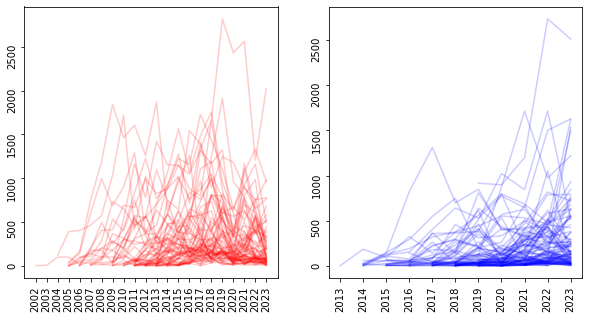

In [115]:
age_filter = dfa['age'] > 28
old_names = dfa.loc[age_filter, 'Name'].tolist()

dft = dfa.set_index('Name')
dft = dft.filter(regex='^20')
dft['2023'] = dft['2023_scaled']
dft = dft.drop(['2023_scaled'], axis=1)
dft = dft.transpose()
dft = dft.iloc[::-1, :]
df_colors = dfa.transpose()

fig, axs = plt.subplots(1,2, figsize = (10, 5))

for col in dft.columns:
    if col in old_names:
        cplot = 'r'
        axs[0].plot(dft[col], label=col,color=cplot,alpha=.2)
        axs[0].tick_params(rotation=90)
    else:
        cplot = 'b'
        axs[1].plot(dft[col], label=col,color=cplot,alpha=.2)
        axs[1].tick_params(rotation=90)
    
    #plt.xticks(rotation=90)



In [116]:
print(dft)

Name  Remco Evenepoel  Primož Roglič   Geraint Thomas  João Almeida  \
2002              NaN            NaN              NaN           NaN   
2003              NaN            NaN              NaN           NaN   
2004              NaN            NaN              NaN           NaN   
2005              NaN            NaN         2.000000           NaN   
2006              NaN            NaN        43.000000           NaN   
2007              NaN            NaN        32.000000           NaN   
2008              NaN            NaN        36.000000           NaN   
2009              NaN            NaN        55.000000           NaN   
2010              NaN            NaN       308.000000           NaN   
2011              NaN            NaN       565.000000           NaN   
2012              NaN            NaN       203.000000           NaN   
2013              NaN        7.00000       704.000000           NaN   
2014              NaN      131.00000       877.000000           NaN   
2015  

In [135]:
import itertools

ar_list = dfa.loc[dfa['type'] == 'All Rounder', 'Name'].tolist()
c_list = dfa.loc[dfa['type'] == 'Climber', 'Name'].tolist()
sp_list = dfa.loc[dfa['type'] == 'Sprinter', 'Name'].tolist()
uc_list = dfa.loc[dfa['type'] == 'Unclassified', 'Name'].tolist()

#should b 7 slots as we are ignoring unclassified
term_set = [ar_list,ar_list,c_list,c_list,sp_list]

#Use itertools to make all possible combinations taking one var from each set
i = 0
max = 4000000
df_max = pd.DataFrame(index=range(max),columns=range(1))
for var_set in itertools.product(*term_set):
    benefit = dfa.loc[df['Name'].isin(var_set), 'weight_PCS'].sum()
    cost = dfa.loc[df['Name'].isin(var_set), 'Points'].sum()
    df_max.loc[i,['AR','AR2','C','C2','S']] = list(var_set)
    df_max.loc[i,'benefit'] = benefit
    df_max.loc[i,'cost'] = cost
    
    


,0,AR,AR2,C,C2,S,benefit,cost
11077,NaN,Remco Evenepoel,Primož Roglič,Jay Vine,Santiago Buitrago,Mads Pedersen,452.01746,84.0
13585,NaN,Remco Evenepoel,Primož Roglič,Santiago Buitrago,Jay Vine,Mads Pedersen,452.01746,84.0


,0,AR,AR2,C,C2,S,benefit,cost
10207,NaN,Remco Evenepoel,Primož Roglič,Tao Geoghegan Hart,Santiago Buitrago,Mark Cavendish,457.595137,82.0
13551,NaN,Remco Evenepoel,Primož Roglič,Santiago Buitrago,Tao Geoghegan Hart,Mark Cavendish,457.595137,82.0


,0,AR,AR2,C,C2,S,benefit,cost
11005,NaN,Remco Evenepoel,Primož Roglič,Jay Vine,Damiano Caruso,Mark Cavendish,458.816074,80.0
11841,NaN,Remco Evenepoel,Primož Roglič,Damiano Caruso,Jay Vine,Mark Cavendish,458.816074,80.0


,0,AR,AR2,C,C2,S,benefit,cost
11081,NaN,Remco Evenepoel,Primož Roglič,Jay Vine,Santiago Buitrago,Mark Cavendish,488.01504,78.0
13589,NaN,Remco Evenepoel,Primož Roglič,Santiago Buitrago,Jay Vine,Mark Cavendish,488.01504,78.0


,0,AR,AR2,C,C2,S,benefit,cost
11955,NaN,Remco Evenepoel,Primož Roglič,Damiano Caruso,Santiago Buitrago,Mark Cavendish,493.312321,76.0
13627,NaN,Remco Evenepoel,Primož Roglič,Santiago Buitrago,Damiano Caruso,Mark Cavendish,493.312321,76.0


In [172]:
# generate all combinations of length 4
df_disp_cut = dfa.loc[(dfa['type'] == 'Unclassified') & (dfa['Points'] == 4)]
#print(df_disp_cut.nlargest(10, 'weight_PCS')
tabplot = df_disp_cut.nlargest(4, 'weight_PCS')
display(tabplot)

uc_list = dfa.loc[(dfa['weight_PCS'] >45) & (dfa['type'] == 'Unclassified'),'Name'].unique().tolist()

term_set = [uc_list,uc_list,uc_list,uc_list]
df_max_uc = pd.DataFrame(index=range(len(uc_list)**4),columns=range(1))
i = 0
for var_set in itertools.product(*term_set):
    benefit = dfa.loc[df['Name'].isin(var_set), 'weight_PCS'].sum()
    cost = dfa.loc[df['Name'].isin(var_set), 'Points'].sum()
    df_max_uc.loc[i,['UC1','UC2','UC3','UC4']] = list(var_set)
    df_max_uc.loc[i,'benefit'] = benefit
    df_max_uc.loc[i,'cost'] = cost
    i = i+1

,Unnamed: 0,type,Points,Name,url_fix,Name_clean,dob,weight,height,oneday,...,SPC_past3,impr_2023_scaled,impr_2022,impr_2021,mean_impr,log_impr,age_quantile,old_young,weight_PCS,age
154,154,Unclassified,4,Stephen Williams,NaN,NaN,26.0,59.0,1.83,120.0,...,32.945005,0.515927,-0.845488,3.605498,1.091979,1.847636,Q2,Young,60.948259,26.0
134,134,Unclassified,4,Laurenz Rex,NaN,NaN,23.0,82.0,1.93,222.0,...,32.353585,1.127983,0.351398,NaN,0.739691,1.536495,Q1,Young,49.824521,23.0
156,156,Unclassified,4,Samuele Zoccarato,NaN,NaN,25.0,74.0,1.83,128.0,...,22.085552,1.305486,-0.182322,3.988984,1.704049,2.116096,Q2,Young,46.821369,25.0
137,137,Unclassified,4,Clément Russo,NaN,NaN,28.0,73.0,1.86,388.0,...,34.228853,0.124270,-0.277122,1.622259,0.489802,1.315793,Q3,Old,45.182087,28.0


In [197]:
df_max_uc_dedup = df_max_uc.loc[(df_max_uc['UC1'] != df_max_uc['UC2']) & (df_max_uc['UC1'] != df_max_uc['UC3']) & (df_max_uc['UC2'] != df_max_uc['UC3']) & (df_max_uc['UC1'] != df_max_uc['UC4'])& (df_max_uc['UC2'] != df_max_uc['UC4'])& (df_max_uc['UC3'] != df_max_uc['UC4'])]

for num in range(16, 35, 2):

    leftover = 100-num
 
    #Get the main 5
    df_disp = df_max[df_max['cost'] == leftover]
    tabplot = df_disp.nlargest(1, 'benefit')
    display(tabplot)
    sum_main5 = tabplot.loc[:,'benefit'].sum()
    #Get the Unclassified riders
    df_disp = df_max_uc_dedup[df_max_uc_dedup['cost'] == num]
    tabplot = df_disp.nlargest(1, 'benefit')
    sum_uc = tabplot.loc[:,'benefit'].sum()
    display(tabplot)
    benefit_total = sum_uc+sum_main5
    print(f'The team above yields a total benefit of: {benefit_total}')


,0,AR,AR2,C,C2,S,benefit,cost
11077,NaN,Remco Evenepoel,Primož Roglič,Jay Vine,Santiago Buitrago,Mads Pedersen,452.01746,84.0


,0,UC1,UC2,UC3,UC4,benefit,cost
135179,NaN,Laurenz Rex,Clément Russo,Stephen Williams,Samuele Zoccarato,202.776236,16.0


The team above yields a total benefit of: 654.7936963516613


,0,AR,AR2,C,C2,S,benefit,cost
10207,NaN,Remco Evenepoel,Primož Roglič,Tao Geoghegan Hart,Santiago Buitrago,Mark Cavendish,457.595137,82.0


,0,UC1,UC2,UC3,UC4,benefit,cost
62779,NaN,Ben Healy,Laurenz Rex,Stephen Williams,Samuele Zoccarato,350.012239,18.0


The team above yields a total benefit of: 807.6073760112339


,0,AR,AR2,C,C2,S,benefit,cost
11005,NaN,Remco Evenepoel,Primož Roglič,Jay Vine,Damiano Caruso,Mark Cavendish,458.816074,80.0


,0,UC1,UC2,UC3,UC4,benefit,cost
60738,NaN,Ben Healy,Lorenzo Rota,Laurenz Rex,Stephen Williams,443.712278,20.0


The team above yields a total benefit of: 902.528351981732


,0,AR,AR2,C,C2,S,benefit,cost
11081,NaN,Remco Evenepoel,Primož Roglič,Jay Vine,Santiago Buitrago,Mark Cavendish,488.01504,78.0


,0,UC1,UC2,UC3,UC4,benefit,cost
59838,NaN,Ben Healy,Aurélien Paret-Peintre,Lorenzo Rota,Stephen Williams,483.974072,22.0


The team above yields a total benefit of: 971.9891118430369


,0,AR,AR2,C,C2,S,benefit,cost
11955,NaN,Remco Evenepoel,Primož Roglič,Damiano Caruso,Santiago Buitrago,Mark Cavendish,493.312321,76.0


,0,UC1,UC2,UC3,UC4,benefit,cost
19038,NaN,Stefan Küng,Ben Healy,Lorenzo Rota,Stephen Williams,535.602252,24.0


The team above yields a total benefit of: 1028.9145730522425


,0,AR,AR2,C,C2,S,benefit,cost
12145,NaN,Remco Evenepoel,Primož Roglič,Damiano Caruso,Einer Augusto Rubio,Mark Cavendish,491.614887,74.0


,0,UC1,UC2,UC3,UC4,benefit,cost
18991,NaN,Stefan Küng,Ben Healy,Aurélien Paret-Peintre,Lorenzo Rota,564.740308,26.0


The team above yields a total benefit of: 1056.355195286094


,0,AR,AR2,C,C2,S,benefit,cost
13893,NaN,Remco Evenepoel,Primož Roglič,Santiago Buitrago,Einer Augusto Rubio,Mark Cavendish,520.813853,72.0


,0,UC1,UC2,UC3,UC4,benefit,cost
8951,NaN,Magnus Cort,Stefan Küng,Ben Healy,Lorenzo Rota,549.471755,28.0


The team above yields a total benefit of: 1070.285607856421


,0,AR,AR2,C,C2,S,benefit,cost
31183,NaN,Remco Evenepoel,João Almeida,Jay Vine,Santiago Buitrago,Mark Cavendish,500.93725,70.0


,0,UC1,UC2,UC3,UC4,benefit,cost
951,NaN,Filippo Ganna,Stefan Küng,Ben Healy,Lorenzo Rota,575.840688,30.0


The team above yields a total benefit of: 1076.7779371149593


,0,AR,AR2,C,C2,S,benefit,cost
32057,NaN,Remco Evenepoel,João Almeida,Damiano Caruso,Santiago Buitrago,Mark Cavendish,506.23453,68.0


,0,UC1,UC2,UC3,UC4,benefit,cost
447,NaN,Filippo Ganna,Magnus Cort,Stefan Küng,Ben Healy,510.137041,32.0


The team above yields a total benefit of: 1016.3715718619296


,0,AR,AR2,C,C2,S,benefit,cost
32247,NaN,Remco Evenepoel,João Almeida,Damiano Caruso,Einer Augusto Rubio,Mark Cavendish,504.537097,66.0


,0,UC1,UC2,UC3,UC4,benefit,cost


The team above yields a total benefit of: 504.5370967495535


In [186]:
#Ganna case 
num_list = [16,18,20,22,24]
df_max_uc_dedup = df_max_uc.loc[(df_max_uc['UC1'] != df_max_uc['UC2']) & (df_max_uc['UC1'] != df_max_uc['UC3']) & (df_max_uc['UC2'] != df_max_uc['UC3']) & (df_max_uc['UC1'] != df_max_uc['UC4'])& (df_max_uc['UC2'] != df_max_uc['UC4'])& (df_max_uc['UC3'] != df_max_uc['UC4'])]
for num in num_list:
    leftover = num
    df_disp = df_max_uc_dedup[df_max_uc_dedup['cost'] == leftover]
    tabplot = df_disp.nlargest(1, 'benefit')
    display(tabplot)

,0,UC1,UC2,UC3,UC4,benefit,cost
135179,NaN,Laurenz Rex,Clément Russo,Stephen Williams,Samuele Zoccarato,202.776236,16.0


,0,UC1,UC2,UC3,UC4,benefit,cost
62779,NaN,Ben Healy,Laurenz Rex,Stephen Williams,Samuele Zoccarato,350.012239,18.0


,0,UC1,UC2,UC3,UC4,benefit,cost
60738,NaN,Ben Healy,Lorenzo Rota,Laurenz Rex,Stephen Williams,443.712278,20.0


,0,UC1,UC2,UC3,UC4,benefit,cost
59838,NaN,Ben Healy,Aurélien Paret-Peintre,Lorenzo Rota,Stephen Williams,483.974072,22.0


,0,UC1,UC2,UC3,UC4,benefit,cost
19038,NaN,Stefan Küng,Ben Healy,Lorenzo Rota,Stephen Williams,535.602252,24.0


In [145]:
print(df_max.iloc[1698618,:])

0                       NaN
AR           Rigoberto Urán
AR2          Rigoberto Urán
C             Carlos Verona
C2            Carlos Verona
S           Andrea Vendrame
benefit          148.328965
cost                   20.0
Name: 1698618, dtype: object


In [167]:
print(len(uc_list)**4)

160000
